In [ ]:
#default_exp transparent

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib notebook 

# Transparent thinking  

> No scattering makes life easier 


Simulation of color change over time requires a structural color physics model. In the general case of scattering colorants this is quite a challenge. First we need to know the optical absorption (*K*) and scattering (*S*) properties of all paints in the palette. Furthermore we need to know the distribution of all paints. Finally this stratigraphic model data then needs to be fed into the complicated mathematical machinery of Kubelka-Munk equations. 

Pff, all together a rather complicated problem. We will deal with this later. Fortunately, the modeling of transparent (i.e. non-scattering) colors such as inks and dyes is much simpler. An object can be thought of as a background with a number of transparent colored layers on top. These layers act like filters. Their ordering does not matter. Such colors are called subtractive. The colors of a color photograph are the result of the combined filter action of specific amounts of cyan, magenta and yellow. 

## Creating a stratigraphic model 

In a typical situation we are confronted with a drawing or photograph and we do not have information about the palette of inks or the set of dyes that constitute the primaries. Also we do not know how these colorants are distributed. We magically need to separate the optical properties of the colorants, and come up with a concentration or thickness map for each colorant layer. 

Let's load the `kaleidoscope()` test image, and learn how we can separate the cyan, magenta and yellow primary colors. 

In [ ]:
from inktime import kaleidoscope 

test_img = kaleidoscope()

<IPython.core.display.Javascript object>


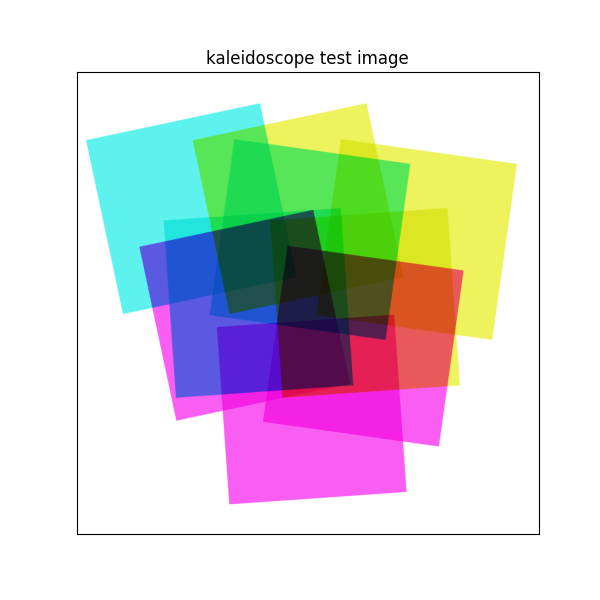

In [ ]:
#hide_input 
import matplotlib.pyplot as plt
import numpy as np 

fig, ax = plt.subplots(figsize=[6, 6])
ax.imshow(test_img)
ax.set_xticks([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('kaleidoscope test image');

A first step in the construction of a stratigraphic model is the detection of primary colors as the corners of the normalized optical density palette histogram. 

<IPython.core.display.Javascript object>


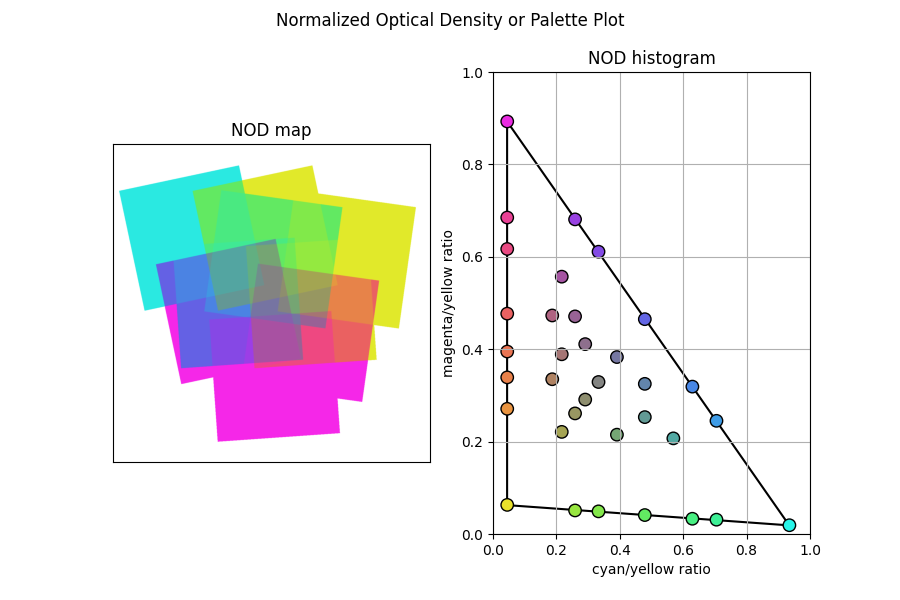

In [ ]:
from inktime import palette_plot, primaries, optical_density, transmission   

palette_plot(test_img);

Similar colors in the NOD map represent a single colorant mixing ratio. The coordinates of the corners (cyan, magenta and yellow) of the triangle in the NOD histogram are the ink primaries that we seek. They can be computed with the `primaries()` function. 

In [ ]:
M = primaries(test_img)
M

array([[0.89285714, 0.04464286, 0.0625    ],
       [0.01869159, 0.93457944, 0.04672897],
       [0.0625    , 0.04464286, 0.89285714]])

The rows in this matrix contain the normalized optical densities for the three primary inks. Now we can continue and construct a three layer stratigraphic model. In other words, we will compute separate transmission images for the three inks that were used. 

The essential idea for this computation is work in optical density space because quantities then scale linearly with concentrations. This allows us make use of the inverse transformation matrix of the primaries. The inverse matrix can be calculated with the numpy function `numpy.linalg.inv()`. 

In [ ]:
M_inv = np.linalg.inv(M)
M_inv

array([[ 1.12638568, -0.05016409, -0.07622159],
       [-0.01863194,  1.07351149, -0.05487954],
       [-0.0779154 , -0.05016409,  1.12807949]])

If we now compute optical density image, we can multiply with the inverse transformation matrix and get the concentrations image. 

In [ ]:
od_img = optical_density(test_img, normalize=False)

# temporarily flatten image into list 
img_shape = od_img.shape
od_list = od_img.reshape(-1, 3)

# matrix multiplication 
conc_list = od_list @ M_inv

# unflatten list into image 
concs_img = conc_list.reshape(img_shape)

# seperate images for cyan, magenta and yellow 
cyan_conc_img, magenta_conc_img, yellow_conc_img = concs_img.transpose(2, 0, 1)

Now we can compute the transmission images from concentration images and their corresponding primaries and plot them. 

<IPython.core.display.Javascript object>


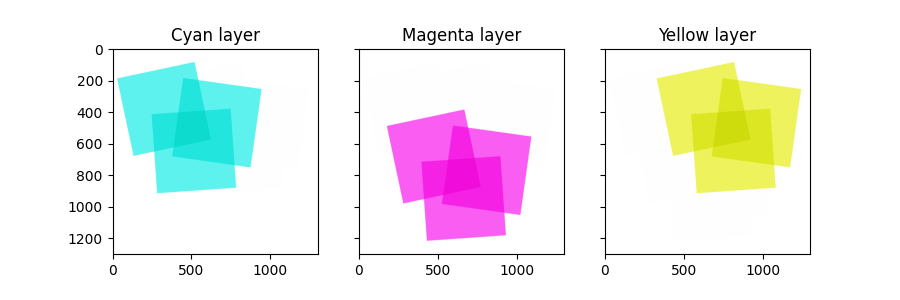

In [ ]:
T_cyan = transmission(cyan_conc_img, M[0])
T_cyan = np.clip(T_cyan, a_min=0, a_max=1)

T_magenta = transmission(magenta_conc_img, M[1])
T_magenta = np.clip(T_magenta, a_min=0, a_max=1) 

T_yellow = transmission(yellow_conc_img, M[2])
T_yellow = np.clip(T_yellow, a_min=0, a_max=1)

fig, [ax0, ax1, ax2] = plt.subplots(ncols=3, figsize=[9, 3], sharex=True, sharey=True)

ax0.imshow(T_cyan)
ax0.set_title(f'Cyan layer')
ax1.imshow(T_magenta)
ax1.set_title('Magenta layer')
ax2.imshow(T_yellow);
ax2.set_title('Yellow layer');

That is it! We have separated the original test image into a stratigraphic model of three separate ink layers. Let's check if we can reconstruct the original test image by overlaying (multiplying transmissions) of the three ink layers. 

<IPython.core.display.Javascript object>


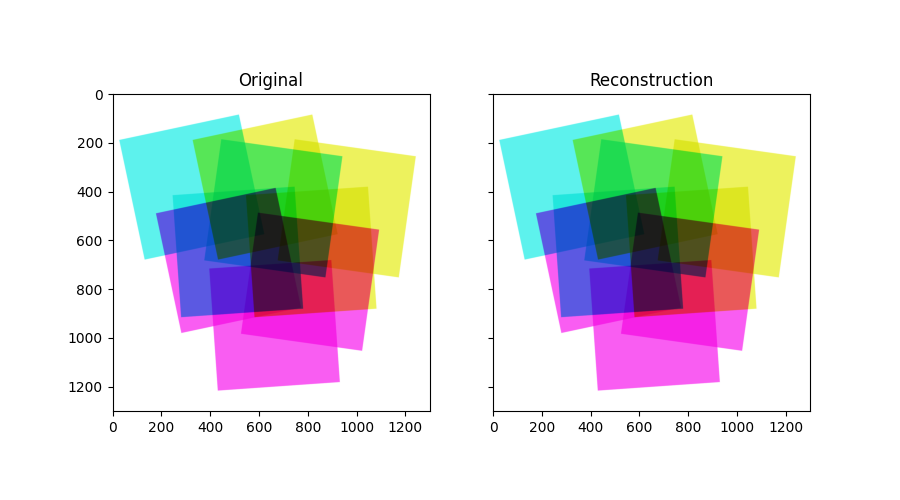

In [ ]:
cyan_x_magenta_x_yellow = T_cyan * T_magenta * T_yellow 

fig, [ax0, ax1] = plt.subplots(ncols=2, figsize=[9, 5], sharex=True, sharey=True)

ax0.imshow(test_img)
ax1.imshow(cyan_x_magenta_x_yellow)

ax0.set_title('Original')
ax1.set_title('Reconstruction');

These computations above are implemented in the `Stratigraphy()` class.  

In [ ]:
from inktime import Stratigraphy
s = Stratigraphy(test_img)

<IPython.core.display.Javascript object>


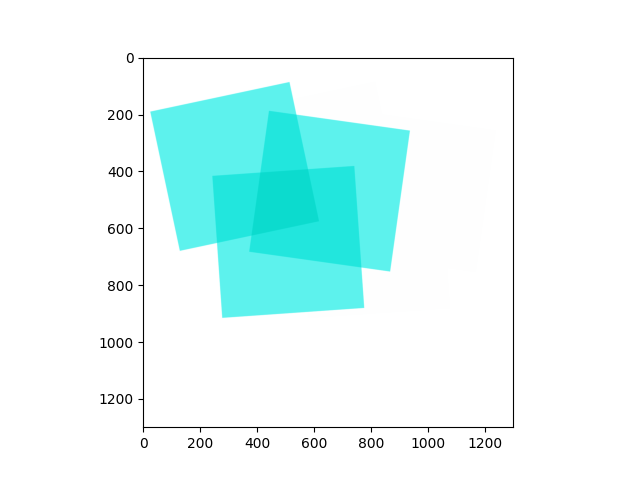

In [ ]:
fig, ax = plt.subplots()
ax.imshow(s.T_cyan); 

**We are now in a position to develop a spectral model and implement chemical kinetics of fading. To be continued...**

In [ ]:
#export 

import numpy as np 
import matplotlib.pyplot as plt 
import skimage.transform as skt 
from scipy.spatial import ConvexHull 

class Stratigraphy(): 
    '''Stratigraphic model for transparent dyes.'''
    
    
    def __init__(self, rgb_img, M=None): 
        '''Create a transparent layers model for a cyan-magenta-yellow dye based color image `rgb_img`.
        
        Parameters
        ----------
        rgb_img : array (height x width x 3)
            Input color image array (height x width x 3).     
        M: None or array (3 x 3), optional 
            Custom optical density matrix for primaries. 
            
        Returns
        -------
        Stratigraphy object 
            
        ''' 
        
        self.rgb_img = rgb_img 
        
        self.M = primaries(self.rgb_img) 
        self.M_inv = np.linalg.inv(self.M) 
        
        self.od_img = optical_density(self.rgb_img, normalize=False)

        # temporarily flatten image into list 
        img_shape = self.od_img.shape
        od_list = self.od_img.reshape(-1, 3)

        # matrix multiplication 
        conc_list = od_list @ self.M_inv

        # unflatten list into image 
        self.concs_img = conc_list.reshape(img_shape)

        # seperate images for cyan, magenta and yellow 
        self.cyan_conc_img, self.magenta_conc_img, self.yellow_conc_img = self.concs_img.transpose(2, 0, 1)
        
        
        self.T_cyan = transmission(self.cyan_conc_img, self.M[0])
        self.T_cyan = np.clip(self.T_cyan, a_min=0, a_max=1)

        self.T_magenta = transmission(self.magenta_conc_img, self.M[1])
        self.T_magenta = np.clip(self.T_magenta, a_min=0, a_max=1) 

        self.T_yellow = transmission(self.yellow_conc_img, self.M[2])
        self.T_yellow = np.clip(self.T_yellow, a_min=0, a_max=1) 
        
        self.model_rgb_img = self.T_cyan * self.T_magenta * self.T_yellow




def transmission(D, K):    
    '''Calculate the RGB or spectral transmission for a colored transparent layer. 
    
    Parameters
    ----------
    D: array (height x width)
        Transparent colorant thickness/concentration map 
    K: tuple-like (n channels)
        Colorant absorption coefficients. 
        For RGB images n=3, for spectral images n wavelength channels 
        
    Returns
    ------- 
    T: array ( height x width x n channels)
        transmission image (height x width x n channels)
    
    '''
    
    # convert possible list or tuple into numpy array 
    K = np.array(K)
    
    # prepare dimensions for broadcasting multiplication  
    D = D[:,:, None]    
    K = K[None, None, :]
    
    # multiply 
    optical_density = D * K 
    
    # Lambert-Beer 
    T = np.exp(-optical_density)
    
    return T


def kaleidoscope(K_CMY=None, bg_color='white', return_layers=False): 
    '''Create 'kaleidoscope' test image. 
    
    Parameters
    ----------
    K_CMY : None, or array (3 x 3)
        If None (default) the kaleidoscope test image is created with default (normalized) 
        primaries `K_CMY` = [[0.9, 0.03, 0.07], [0.05, 0.9, 0.05], [0.02, 0.06, 0.92]]
        For testing purposes custom primaries can be chosen. 
    
    bg_color : 'white', 'yellowish' or RGB tuple 
        For testing purposes custom primbackground color *bg_color* 
    can be chosen. 
    
    return_layers : bool 
        If `return_layers`=True, then layer primaries and transmission images are returned. 
        
    Returns
    -------
    RGB_img : array (1300 x 1300 x 3)
        Kaleidoscope test image 
    '''
    
    # create foil stacks 
    
    foil_0 = np.zeros([1000, 1000])
    foil_0[100:600, 100:600] = 1
    foil_0 = skt.rotate(foil_0, 12)

    foil_1 = np.zeros([1000, 1000])
    foil_1[200:700, 400:900] = 1 
    foil_1 =  skt.rotate(foil_1, -8)

    foil_2 = np.zeros([1000, 1000])
    foil_2[400:900, 250:750] = 1 
    foil_2 =  skt.rotate(foil_2, 4)

    foil_stack = foil_0 + foil_1 + foil_2 
    
    # canvas 
    bg = np.zeros([1300, 1300])

    left_stack = bg.copy()
    left_stack[0:1000, 0:1000] = foil_stack 

    middle_stack = bg.copy()
    middle_stack[300:1300, 150:1150] = foil_stack 

    right_stack = bg.copy()
    right_stack[0:1000, 300:1300] = foil_stack 
    
    # colorize foil stacks 
    
    if K_CMY is None: 
        # default primaries 
        K_CMY = [[1, 0.05, 0.07], [0.02, 1, 0.05], [0.07, 0.05, 1]]
        
    K_cyan, K_magenta, K_yellow = K_CMY 

    T_cyan = transmission(left_stack, K_cyan)
    T_magenta = transmission(middle_stack, K_magenta)
    T_yellow = transmission(right_stack, K_yellow) 
    
    # create background    
  
    if bg_color is 'white': 
        bg_color = np.array([1, 1, 1])    
    elif bg_color is 'yellowish':  
        bg_color = np.array([0.92, 0.9, 0.85])    
    else: 
        bg_color = np.array(bg_color)

    Rg = np.ones([1300, 1300, 3]) * bg_color  
    
    # compose kaleidoscope image *R* by multiplying transmissions 
    
    RGB_img = Rg * T_cyan * T_magenta * T_yellow 
    
    if return_layers is False: 
        
        return RGB_img
    
    else: 
        
        return K_CMY, [Rg, T_cyan, T_magenta, T_yellow], RGB_img

            
def optical_density(rgb_img, normalize=True, thresh=0): 
    '''Create normalized optical density image from `rgb_img`. 
    
    Parameters
    ----------
    rgb_img : array (height x width x 3)
        Standard rgb image.  
    normalize : bool 
        If True (default) normalize optical density tuple, 
        i.e. make sum x+y+z = 1. 
    thresh : float 
        Normalize only tuples with optical densities above threshold `thresh`. 
        This avoids division by zero errors. 
    '''
        
    # create optical density image 
    od_img = -np.log(rgb_img)

    if normalize: 

        # separate channels to making coding easier 
        od_r, od_g, od_b = od_img.transpose(2, 0, 1)

        # compute normalization 
        norm = od_r + od_g + od_b 

        # normalize only non zero (above threshold) od channels 
        is_ink = norm > thresh

        od_r_norm = od_r.copy()
        od_r_norm[is_ink] = od_r[is_ink] / norm[is_ink]

        od_g_norm = od_g.copy()
        od_g_norm[is_ink] = od_g[is_ink] / norm[is_ink]

        od_b_norm = od_b.copy()
        od_b_norm[is_ink] = od_b[is_ink] / norm[is_ink]

        # recombine channels  
        od_img = np.dstack([od_r_norm, od_g_norm, od_b_norm]) 

    return od_img  



def primaries(rgb_img, method='nearest', thresh=0, verbose=False): 
    '''Find colorant normalized optical density `nod_primaries` from input `rgb_img`. 
    
    Parameters
    ----------
    rgb_img : array (height x width x 3)
        Input RGB image 
    method : 'nearest', 'convex'
        Method for locating gamut triangle corners. 
        If 'nearest' (default) a simple nearest neighbour search is done. 
        If 'convex' a convex hull arond all nod points is computed. Still experimental. 
    verbose : bool 
       If True (default=False) report which method is used. 
    
    '''
    # get ink pixel nods from image 
    
    nod_xy = _get_nod_xy(rgb_img, thresh=thresh)     
    nod_x, nod_y = nod_xy.T 
    
    # locate primaries 
    
    if method is 'nearest': 
        if verbose: 
            print('Returning CMY triangle nod primaries')
        cyan_i = np.argmin((nod_x - 1)**2 + (nod_y - 0)**2)
        magenta_i = np.argmin((nod_x - 0)**2 + (nod_y - 1)**2)
        yellow_i = np.argmin((nod_x - 0)**2 + (nod_y - 0)**2) 
        
        nod_primaries = np.array([nod_xy[cyan_i], nod_xy[magenta_i], nod_xy[yellow_i]])
        
    if method is 'convex': 
        if verbose: 
            print('Returning convex hull vertices nod primaries (arbitrary order)')
        hull = ConvexHull(nod_xy)
        nod_primaries = nod_xy[hull.vertices][0:-1] 
        
    ## extend with z 
    zzz = 1 - np.sum(nod_primaries, axis=1)
    zzz = zzz.reshape(3, 1) 
    nod_primaries = np.hstack([nod_primaries, zzz])
    
    assert np.all(np.sum(nod_primaries, axis=1) == [1, 1, 1]), 'normalisation error'
    
    return nod_primaries 


def _get_nod_xy(rgb_img, thresh=0): 
    '''Convert ink pixels in *rgb_img* into normalized optical density tuple list. '''
    
    nod_img = optical_density(rgb_img, normalize=True, thresh=thresh)  
    norm = np.sum(nod_img, axis=2) 
    is_ink = norm > thresh 
    
    nod_xyz = nod_img[is_ink]
    nod_xy = nod_xyz[:, 0:2]
    
    return nod_xy


def palette_plot(rgb_img):
    '''Plot normalized optical density (NOD) map and histogram for `rgb_img`. 
    
    
    Similar colors in the NOD map represent similar mixture ratios of primaries. 
    Triangle corners in the NOD histogram represent the cyan, magenta and yellow primaries. 
    
    Parameters
    ----------
    rgb_img : array (height x width x 3)
        Input RGB image 
    
    Returns
    -------
    fig, axs : plot figure and axes
    
    '''

    bins = 500 
    step = 1 / bins 
    blob_npix = 100 
    
    nod_img = optical_density(rgb_img)
    
    nod_rgb_img = np.exp(-2 * nod_img)

    # convert rgb image into non-zero nod tuple list 
    nod_xy = _get_nod_xy(rgb_img)
    nod_x, nod_y = nod_xy.T 

    # compute histogram 
    counts = np.histogram2d(nod_x, nod_y, bins=bins, range=[[0, 1], [0, 1]])[0] 

    # create CMY color triangle 
    centroids = np.arange(0, 1, step) + step/2

    xx, yy = np.meshgrid(centroids, centroids)
    zz = 1 - xx - yy  
    zz[zz < 0] = 0

    is_out = xx + yy > 1 
    xx[is_out] = 0
    yy[is_out] = 0 
    zz[is_out] = 0 

    xyz_triangle = np.dstack([xx, yy, zz]) 
    rgb_triangle = np.exp(-2*xyz_triangle)

    is_significant = counts > blob_npix

    blob_x = xx[is_significant]
    blob_y= yy[is_significant]
    blob_rgb = rgb_triangle[is_significant]
    
    # draw primaries triangle 
    nod_primaries = primaries(rgb_img)
    nod_primaries = nod_primaries[:, 0:2] # just xy 
    nod_primaries = np.r_[nod_primaries, nod_primaries[[0]]] # close polygon 
    nod_y, nod_x = nod_primaries.T

    fig, [ax0, ax1] = plt.subplots(ncols=2, figsize=[9, 6])
    fig.suptitle('Normalized Optical Density or Palette Plot')
    
    ax0.imshow(nod_rgb_img)
    ax0.set_title('NOD map')
    ax0.set_xticks([])
    ax0.set_yticks([])
    
    ax1.scatter(blob_x, blob_y, edgecolor='k', facecolor=blob_rgb, s=80)
    ax1.plot(nod_x, nod_y, color='k', zorder=-10)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.grid()
    ax1.set_title('NOD histogram')
    ax1.set_ylabel('magenta/yellow ratio')
    ax1.set_xlabel('cyan/yellow ratio')
    
    return fig, [ax0, ax1]
    
        
        

## Non-negative Matrix Factorization (NMF) 

Another possibility to create a colorant separation is the Non-negative Matrix Factorization algorithm. I need to experiment further to see if this a good alternative to our approach above. See: [scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

As a first step we need to calculate the optical density for the three channels in the RGB image by taking the negative logarithm. 

**To be continued...**

In [ ]:
#hide 
import inktime 
import numpy as np 
from sklearn.decomposition import NMF 

test_img = inktime.kaleidoscope()

od_img = -np.log(test_img)
is_negative = od_img < 0
od_img[is_negative] = 0

shape = od_img.shape

X = od_img.reshape([-1, 3])

#model = NMF(n_components=3, init='random', random_state=0, alpha_W=0.2, alpha_H=0.2, tol=0.000001, max_iter=3000)

#model = NMF(n_components=3, init='nndsvd', random_state=0, solver='cd', beta_loss='frobenius', max_iter=3000, tol=0.000001)
#NMF(n_components=3, init='nndsvda', random_state=0, solver='cd', beta_loss='frobenius', max_iter=3000, tol=0.000001)

# best before update with alpha=1
#model = NMF(n_components=3, init='nndsvd', random_state=0, alpha_W=1, alpha_H=0, solver='cd', beta_loss='frobenius', max_iter=3000, tol=0.000001)

#not very good at all 
#model = NMF(n_components=3, init='random', random_state=0, alpha_W=0.2, alpha_H=0.2, tol=0.000001, max_iter=3000)

#model = NMF(n_components=3, init='nndsvd', l1_ratio=1.0, alpha=1, random_state=0, tol=0.001, max_iter=300)

# not so good as alpha=1
#model = NMF(n_components=3, init='nndsvd', alpha_W=1, alpha_H=0, random_state=0, tol=0.001, max_iter=300)

# not so good as alpha=1
#model = NMF(n_components=3, init='nndsvd', alpha_W=0.33, alpha_H=0, random_state=0, tol=0.001, max_iter=300)

#model = NMF(n_components=3, init='nndsvd', alpha=1, random_state=0, tol=0.001, max_iter=300)

#model = NMF(n_components=3, init='nndsvd', alpha_W=1, alpha_H=0, random_state=0, tol=0.001, 
#            max_iter=3000, regularization='transformation')

W = model.fit_transform(X)
H = model.components_

W_img = W.reshape(shape)


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[9, 7])

axs[0, 0].imshow(W_img[:,:,0])
axs[0, 1].imshow(W_img[:,:,1])
axs[0, 2].imshow(W_img[:,:,2])

axs[1, 0].imshow(transmission(W_img[:,:,0], H[0]))
axs[1, 1].imshow(transmission(W_img[:,:,1], H[1]))
axs[1, 2].imshow(transmission(W_img[:,:,2], H[2]))

test_img_fit = inktime.transmission(W_img[:,:,0], H[0]) * transmission(W_img[:,:,1], H[1]) * transmission(W_img[:,:,2], H[2])

fig, [ax, ax1] = plt.subplots(ncols=2, figsize=[9, 5])

ax.imshow(test_img)
ax.set_title('original')
ax1.imshow(test_img_fit)
ax1.set_title('factorisation');